In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import curves
import matplotlib
from numpy import percentile
from functools import partial
from matplotlib import pyplot as plt
from joblib import dump, load
from sklearn.model_selection import train_test_split, ShuffleSplit
from sklearn import model_selection, linear_model, metrics, ensemble
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from spark_sklearn.util import createLocalSparkSession
from spark_sklearn import GridSearchCV
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

def calculate_means(numeric_data):
    means = np.zeros(numeric_data.shape[1])
    for j in range(numeric_data.shape[1]):
        to_sum = numeric_data.iloc[:,j].to_numpy()[~numeric_data.iloc[:,j].isnull()]
        means[j] = round(to_sum.sum()/to_sum.size, 0)
    return pd.Series(means, numeric_data.columns)

Загружаем данные

In [4]:
data = pd.read_csv('lv_np_auto.csv').drop(['vehicle_id', 'date', 'days_in_sale_from_price_update', 'start_date', 'contacts', 'favorites', 'promo_features_count'], 1)
data = data.drop(data[data.views > 12000].index)
data.shape

(338869, 17)

In [4]:
data.head()

,user_id,year_id,brand_id,model_id,engine_volume,engine_power,gearbox_type,gearbox_gear_count,km_distance,body_type,body_color,photo_count,owner_count,price,price_number,views,days_count
0,2037,2013,58,1049,4367.0,339,automatic,8.0,72600,suv,black,25,3.0,2940000,3.0,33,1
1,2037,2013,58,1049,4367.0,339,automatic,8.0,72600,suv,black,25,3.0,2940000,3.0,48,2
2,2037,2013,58,1049,4367.0,339,automatic,8.0,72600,suv,black,25,3.0,2940000,3.0,34,3
3,2037,2013,58,1049,4367.0,339,automatic,8.0,72600,suv,black,25,3.0,2940000,3.0,54,4
4,2037,2013,58,1049,4367.0,339,automatic,8.0,72600,suv,black,25,3.0,2940000,3.0,17,5


In [5]:
data.describe()

,user_id,year_id,brand_id,model_id,engine_volume,engine_power,gearbox_gear_count,km_distance,photo_count,owner_count,price,price_number,views,days_count
count,338869.000000,338869.000000,338869.000000,338869.000000,337975.000000,338869.000000,283847.000000,338869.000000,338869.000000,337638.000000,3.388690e+05,338841.00000,338869.000000,338869.000000
mean,1673.535225,2012.657838,70.827225,1573.285600,2013.142052,155.233816,5.651774,113446.461438,15.681851,1.709893,1.076212e+06,3.84465,44.157258,18.695115
std,764.935777,4.502498,37.046303,1417.919596,746.798846,74.844949,1.197018,71809.295245,4.357559,1.205474,1.406998e+06,4.64412,87.923329,16.059002
min,127.000000,1958.000000,2.000000,12.000000,582.000000,19.000000,1.000000,1.000000,0.000000,0.000000,0.000000e+00,0.00000,1.000000,1.000000
25%,1400.000000,2010.000000,46.000000,883.000000,1596.000000,110.000000,5.000000,61450.000000,12.000000,1.000000,4.200000e+05,2.00000,11.000000,6.000000
50%,1662.000000,2013.000000,73.000000,1406.000000,1798.000000,140.000000,6.000000,103000.000000,15.000000,1.000000,6.590000e+05,3.00000,22.000000,14.000000
75%,2273.000000,2016.000000,97.000000,1804.000000,1999.000000,171.000000,6.000000,155000.000000,18.000000,2.000000,1.175000e+06,5.00000,47.000000,27.000000
max,3306.000000,2020.000000,331.000000,10768.000000,6752.000000,650.000000,10.000000,610923.000000,48.000000,16.000000,3.799000e+07,85.00000,8065.000000,91.000000


## Посмотрим на зависимость целевй переменной от признаков
- Сначала рассмотрим зависимость от вещественных признаков

In [6]:
target = data.views
target.describe()

count    338869.000000
mean         44.157258
std          87.923329
min           1.000000
25%          11.000000
50%          22.000000
75%          47.000000
max        8065.000000
Name: views, dtype: float64

Для удобства сразу разделим данные на целевую переменную y и множество признаков X

cat_cols и num_cols содержат названия категориальных и вещественных признаков соответственно 

In [5]:
y = data['views']
X = data.drop(['views'], 1)
cat_cols = ['user_id', 'brand_id', 'model_id', 'gearbox_type', 'body_type', 'body_color']
num_cols = list(set(X.columns.values.tolist()) - set(cat_cols))

Визуализация зависимоти целевой переменной от вещественных признаков

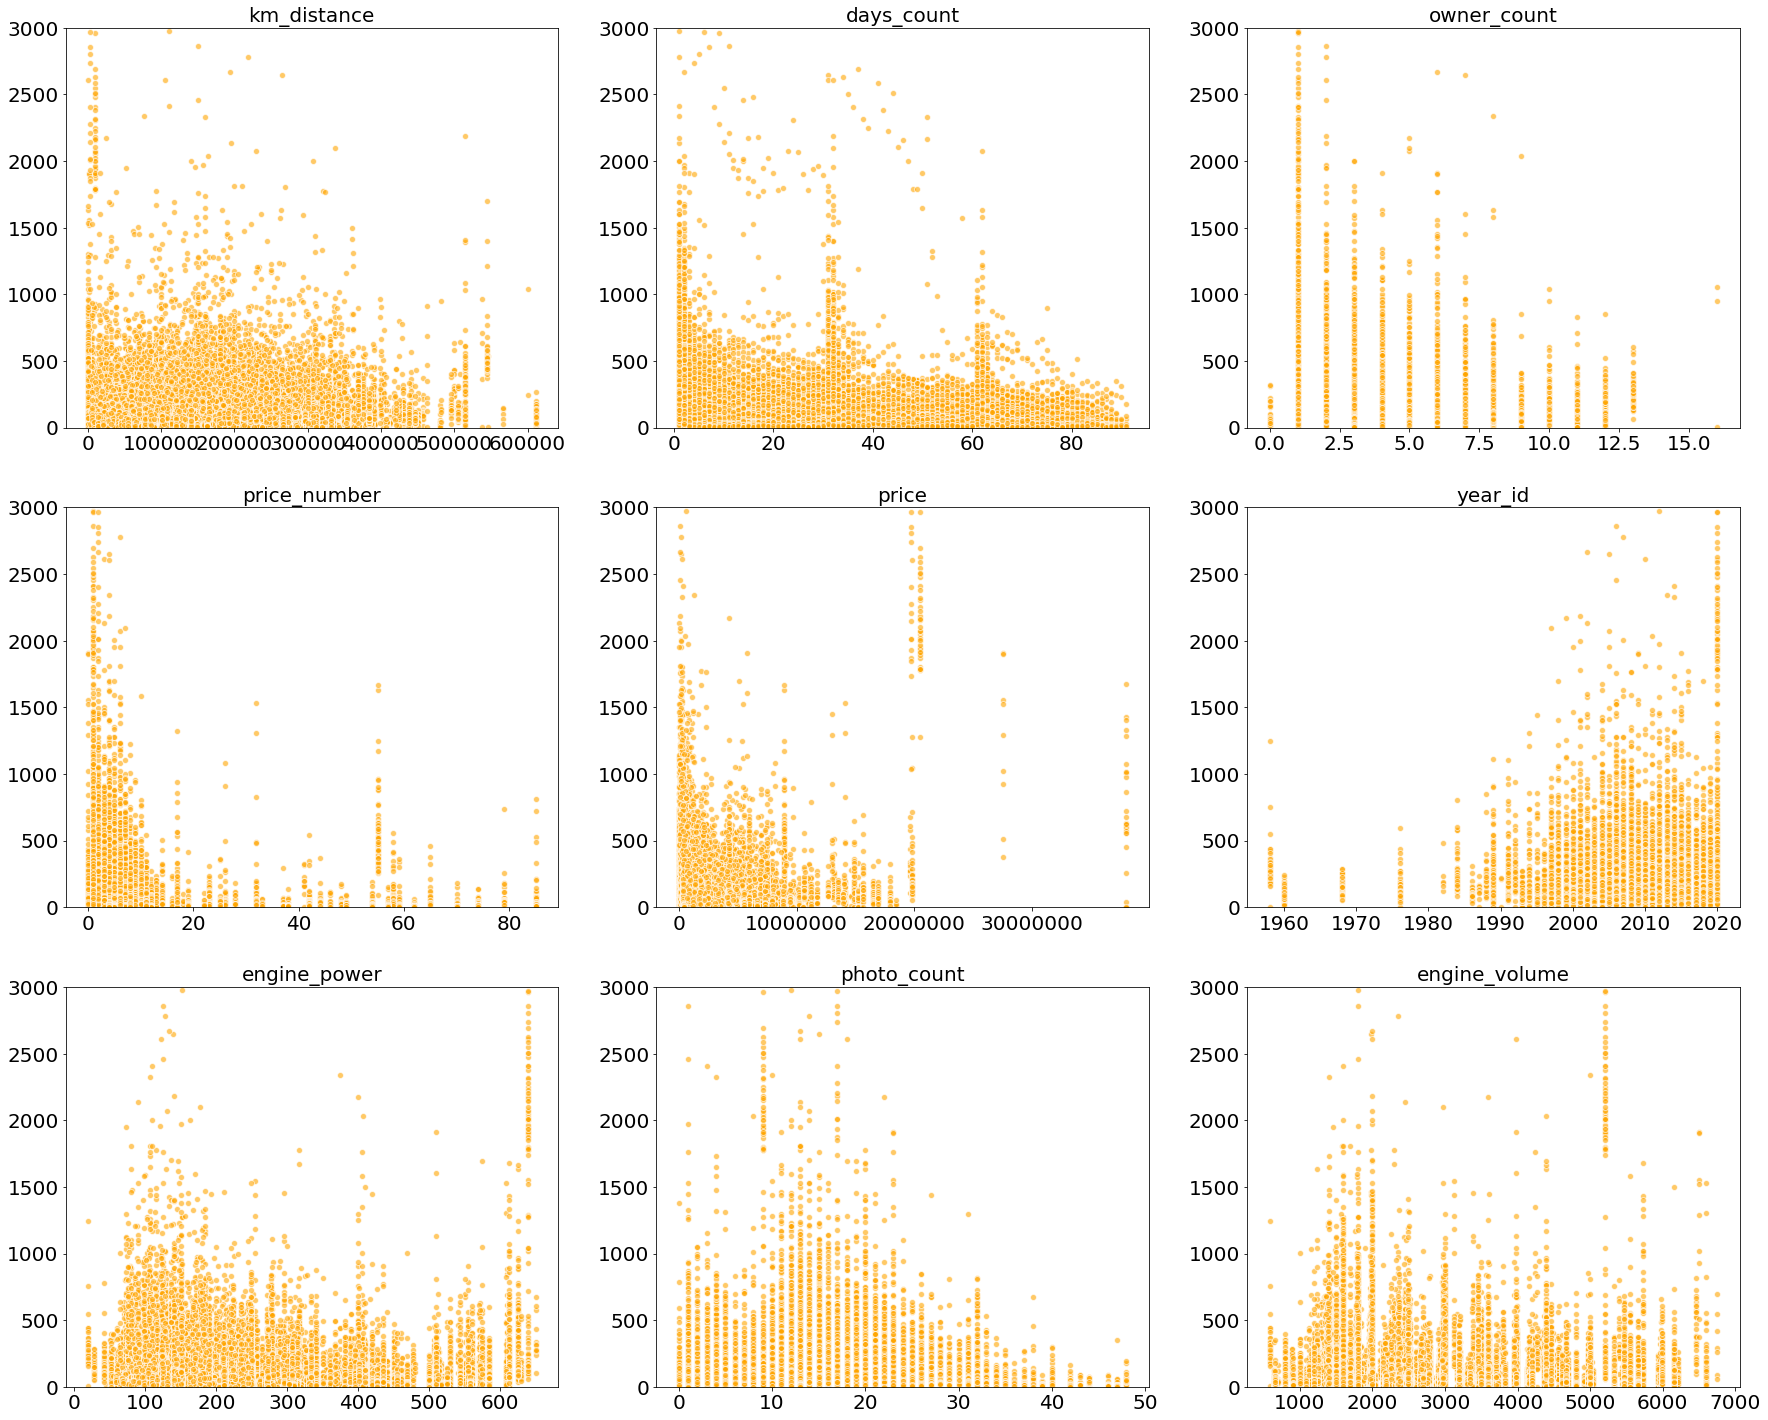

In [38]:
num_cols[0] = 'km_distance'
num_cols[9] = 'gearbox_gear_count'
fig, axs = plt.subplots(3, 3, figsize=(30,25))
for i in range(3):
    for j in range(3):
        axs[i, j].plot(X[num_cols[j+i*3]], y, ls="", marker="o", alpha=0.6, color='orange', markeredgecolor='white')
        axs[i, j].set_title(num_cols[j+i*3], fontsize=20)
        axs[i, j].set_ylim([0,3000])
        axs[i, j].tick_params(labelsize=20)
        axs[i, j].ticklabel_format(style = 'plain')

- Теперь посмотрим на зависимость целевой переменной от категориальных признаков

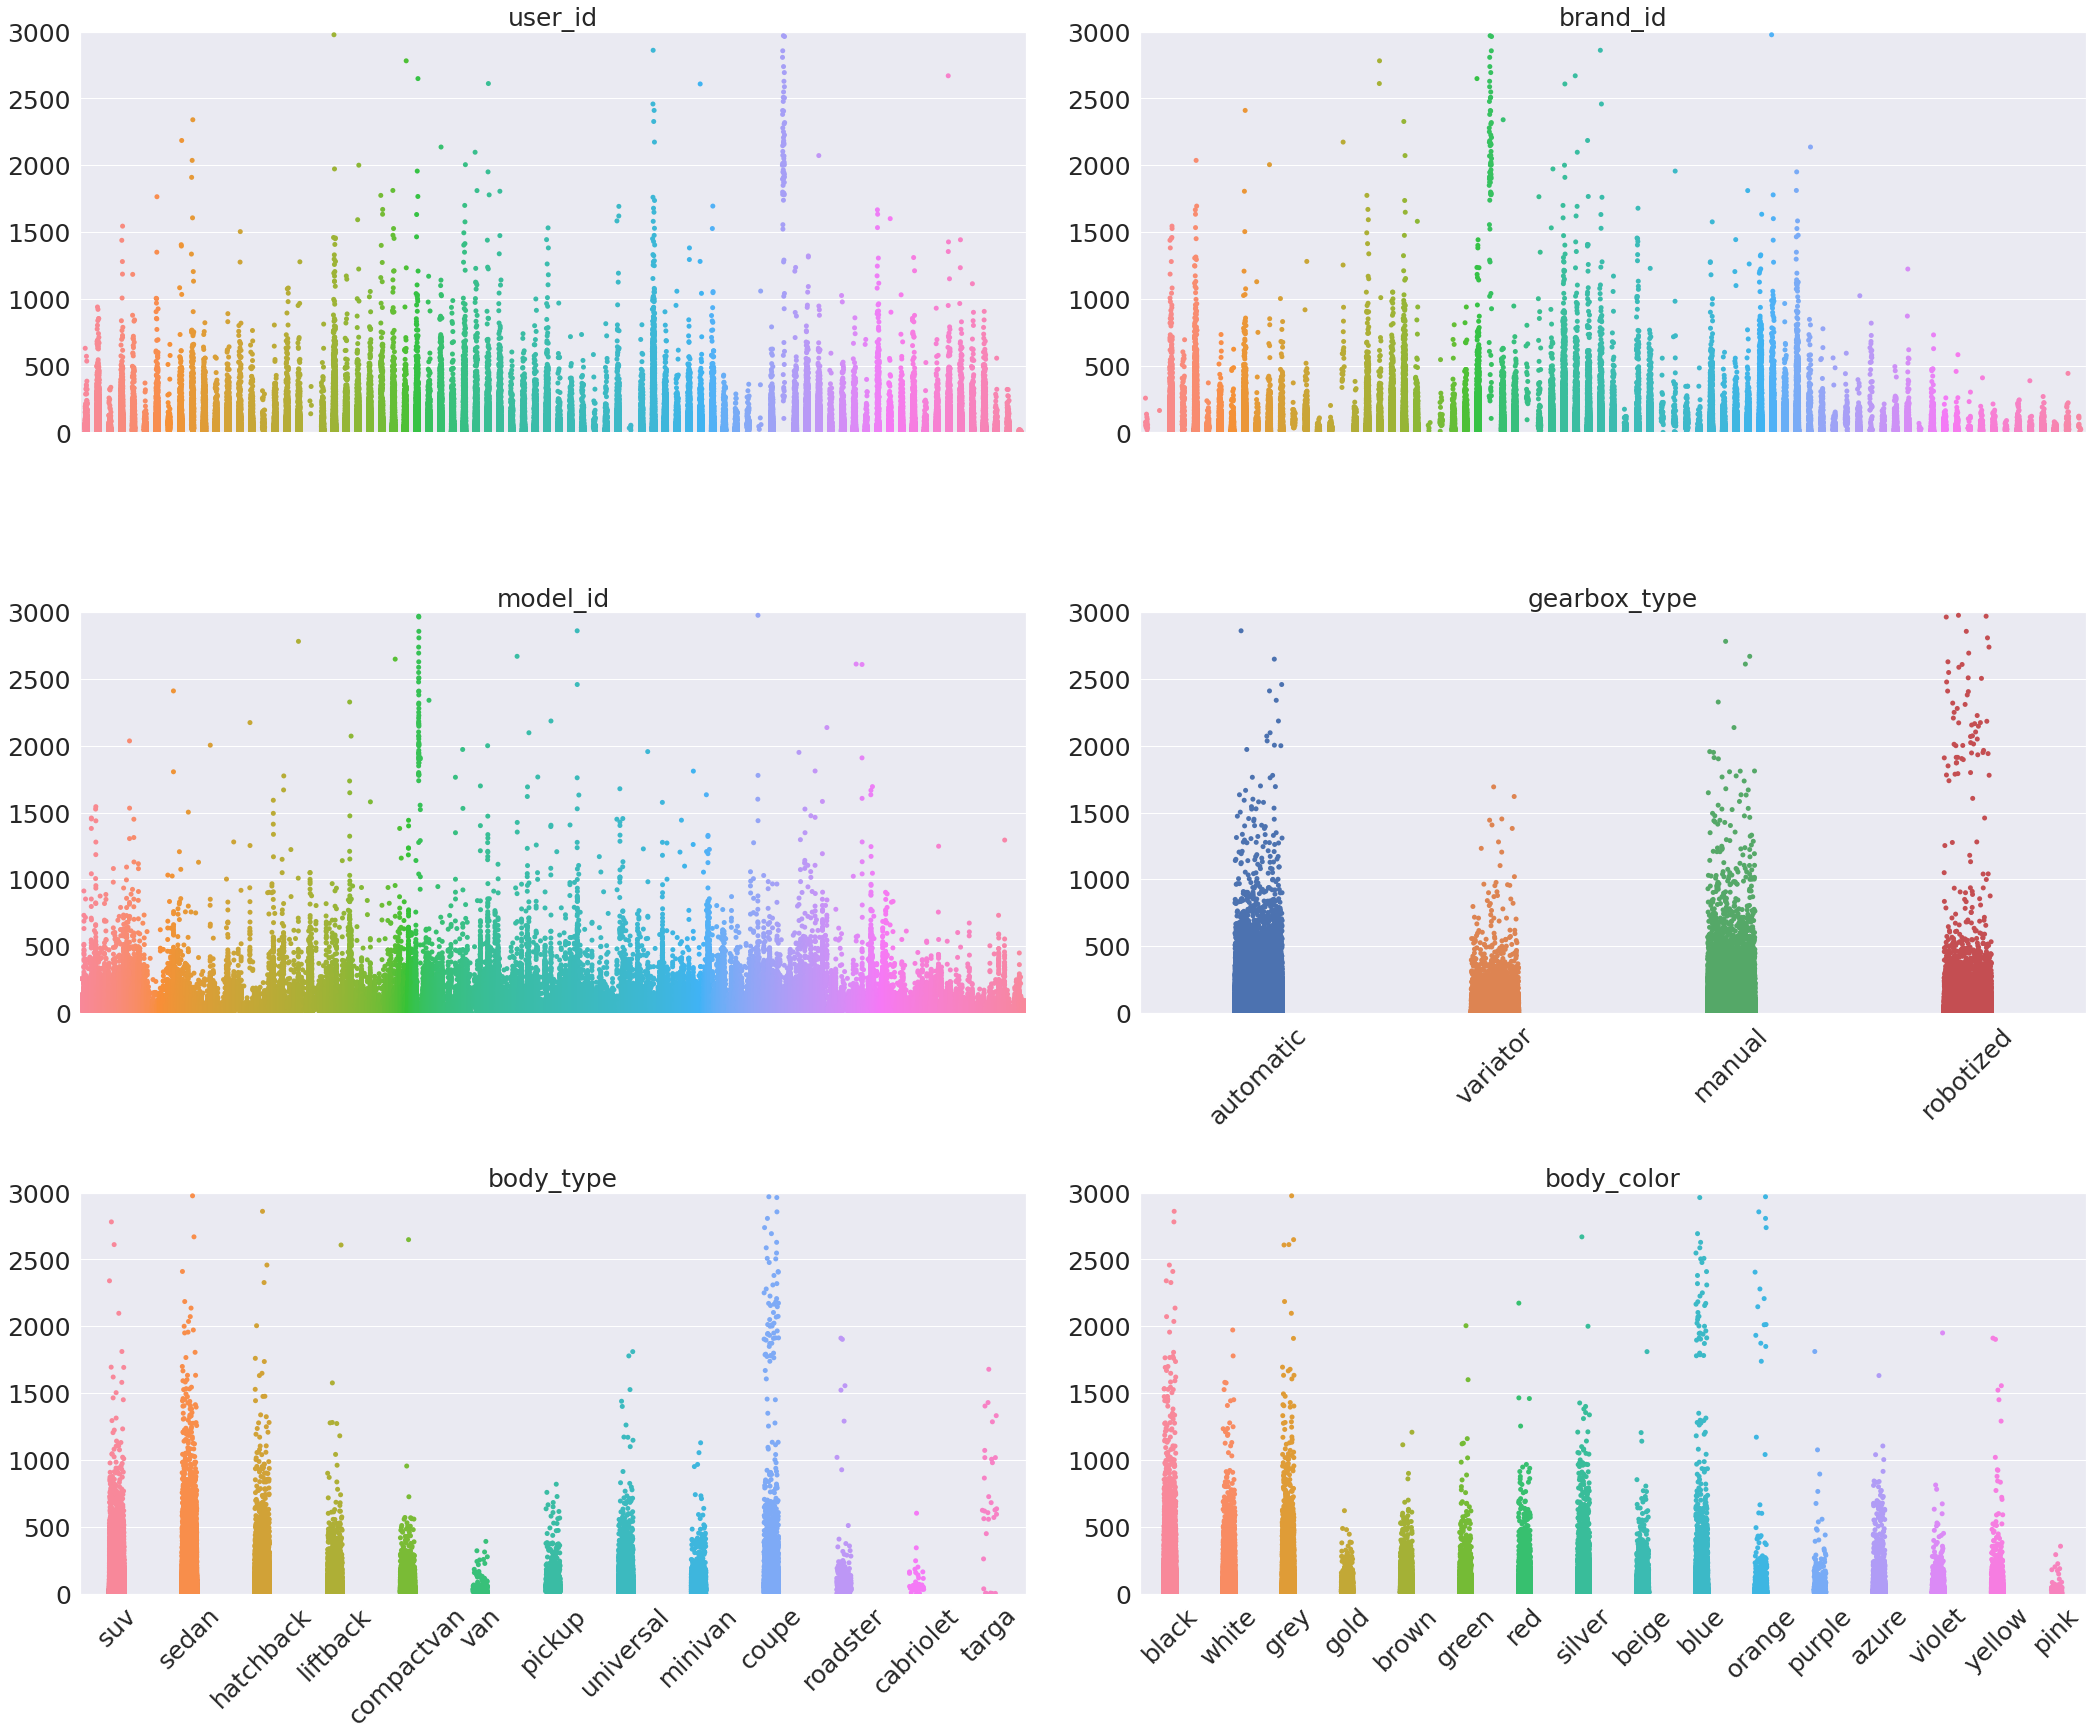

In [67]:
fig, ax = plt.subplots(3, 2, figsize=(30,25))
for i in range(3):
    for j in range(2):
        feature = cat_cols[j+i*2]
        ax[i, j] = sns.stripplot(x=feature, y='views', data=data, ax=ax[i][j])
        ax[i, j].set_title(feature, fontsize=25)
        ax[i, j].set_ylim([0,3000])
        ax[i, j].set_ylabel('')    
        ax[i, j].set_xlabel('')
        ax[i, j].set_xticklabels(ax[i, j].get_xticklabels(), rotation=45) if "_id" not in feature else ax[i, j].set_xticklabels([])
        ax[i, j].tick_params(labelsize=25)
fig.tight_layout()

Строим диаграмму размаха по просмотрам для категориальных признаков.

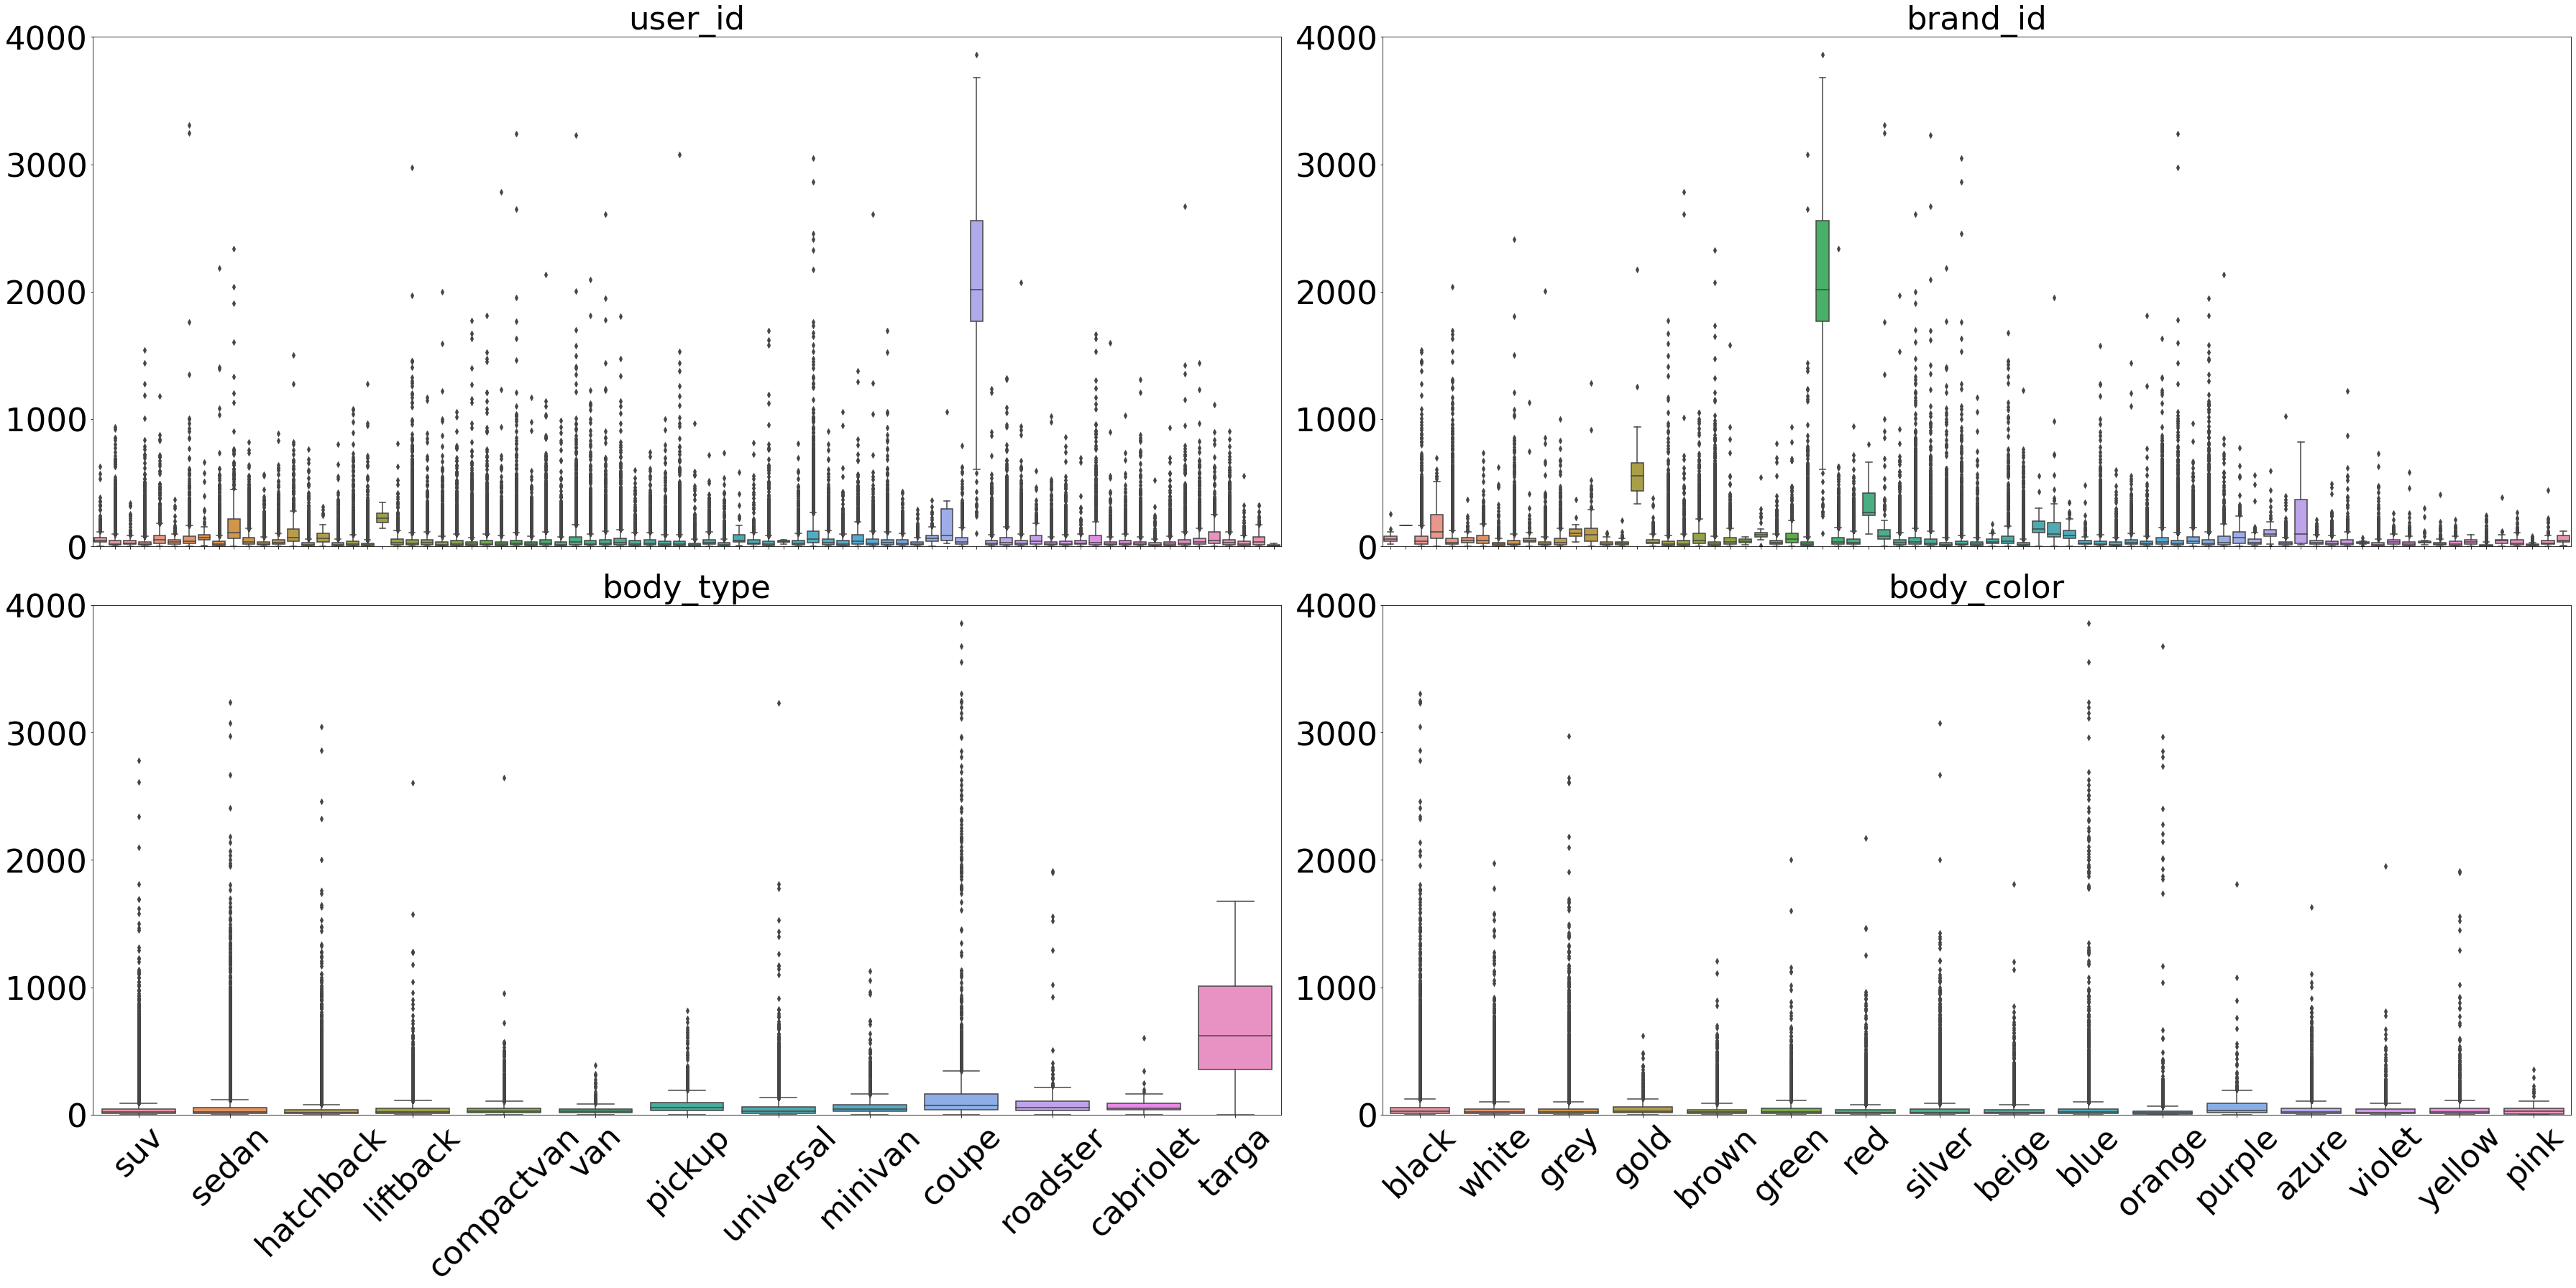

In [44]:
fig, ax = plt.subplots(2, 2, figsize=(50,25))
cat_plot = ['user_id', 'brand_id', 'body_type', 'body_color']
for i in range(2):
    for j in range(2):
        feature = cat_plot[j+i*2]
        ax[i, j] = sns.boxplot(x=feature, y='views', data=data, ax=ax[i][j])
        ax[i, j].set_title(feature, fontsize=45)
        ax[i, j].set_ylim([0,4000])
        ax[i, j].set_ylabel('')    
        ax[i, j].set_xlabel('')
        ax[i, j].set_xticklabels(ax[i, j].get_xticklabels(), rotation=45) if "_id" not in feature else ax[i, j].set_xticklabels([])
        ax[i, j].tick_params(labelsize=45)
fig.tight_layout()

Большое количество отдельных точек на рисунках говорит о том, что в данных много выбросов.

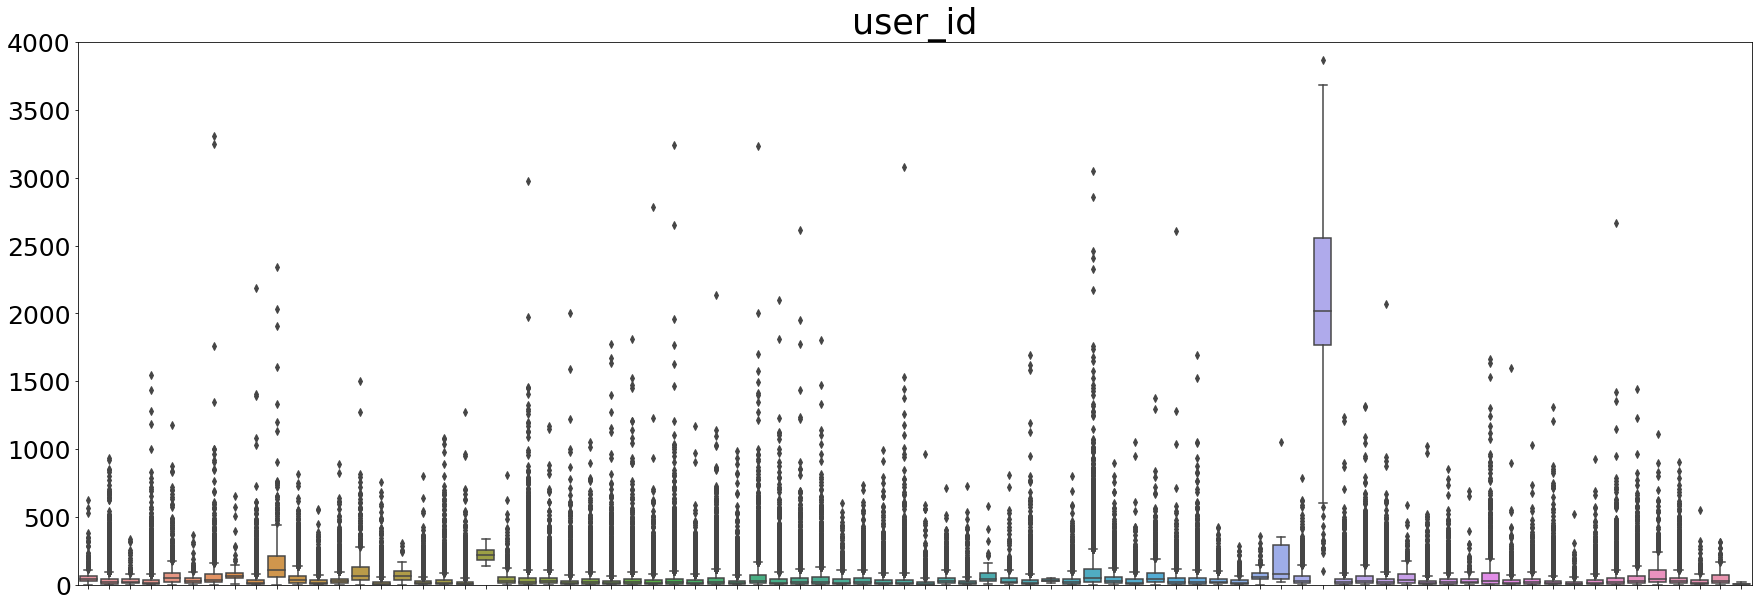

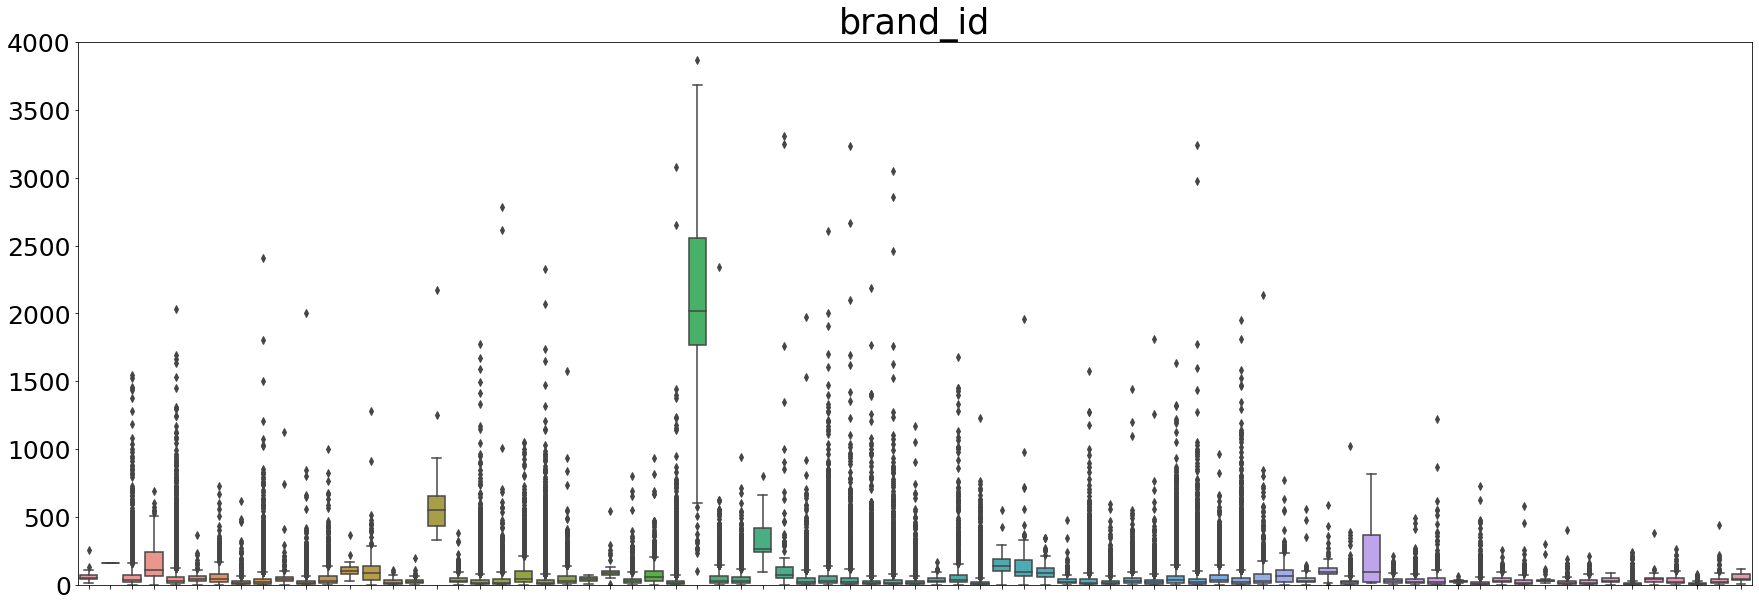

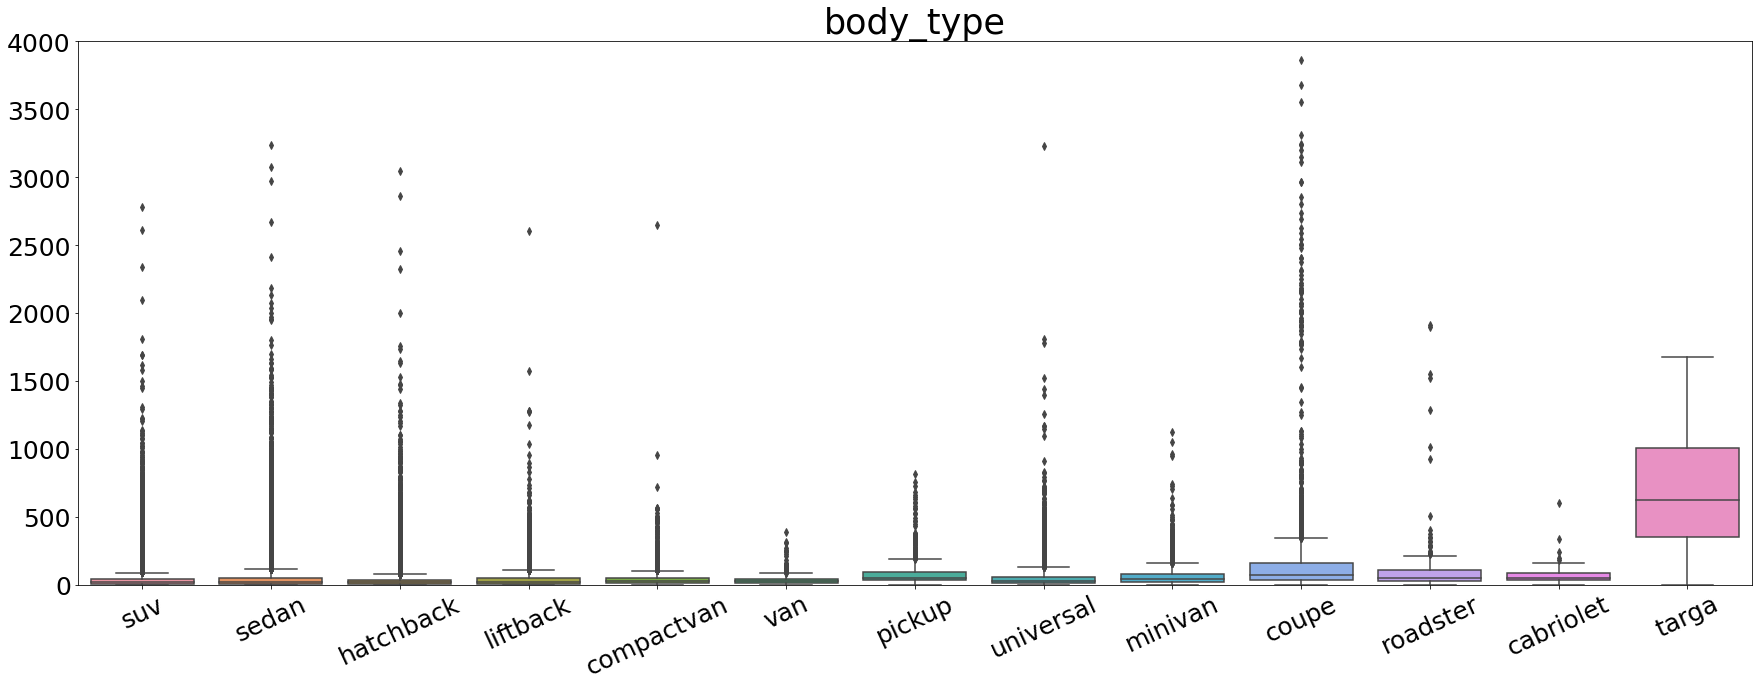

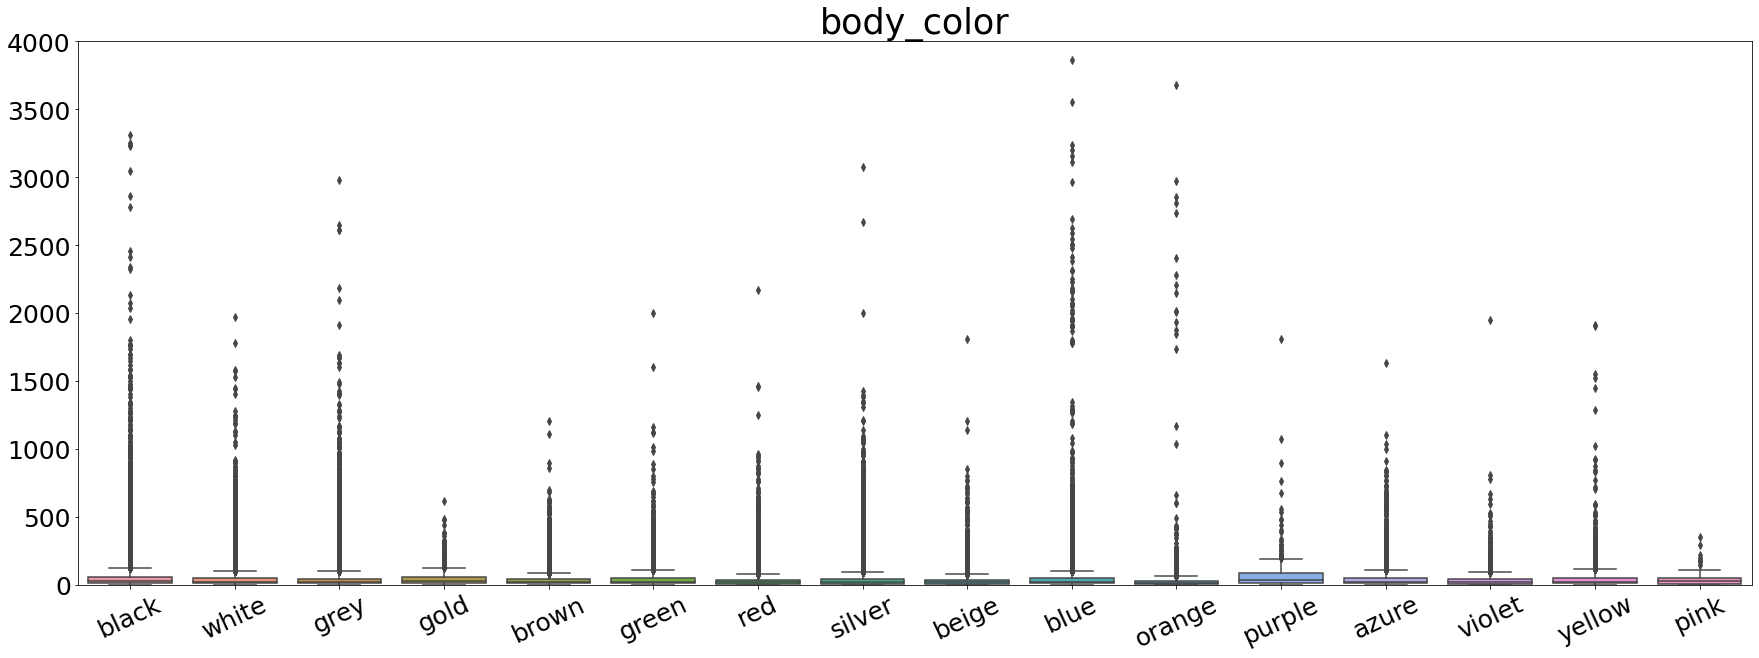

In [43]:
for feature in cat_plot:
    f, ax = plt.subplots(figsize=(30, 10))
    ax = sns.boxplot(x=feature, y='views', data=data)
    ax.set_ylim([0,4000])
    ax.set_title(feature, fontsize=35)
    ax.set_ylabel('')    
    ax.set_xlabel('')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=25) if "_id" not in feature else ax.set_xticklabels([])
    ax.tick_params(labelsize=25)

### Избавляемся от выбросов в данных

 Оставим только те записи, количество просмотров в которых находится между 20-м и 80-м перцентилями

In [7]:
category='user_id'
users = data[category].unique()

p20 = data.groupby(by=category)[category,'views'].agg(lambda x: percentile(x.views, 20))
p80 = data.groupby(by=category)[category,'views'].agg(lambda x: percentile(x.views, 80))

In [83]:
cleaned_by_user = pd.DataFrame()

for i,m in enumerate(users):
    cleaned_by_user=cleaned_by_user.append(data[((data[category] == m ) & 
        ((data["views"] > p20.user_id[m]) & (data["views"] <= p80.user_id[m]))) ],ignore_index=True)

Кодируем категориальные признаки

In [8]:
# encoded_data = cleaned_by_user
# les = {}
encoded_data = pd.read_csv('cleaned_by_user.csv')
les = load('label_encoder_dict2.joblib')
encoded_data[cat_cols] = encoded_data[cat_cols].astype(str)
for f in cat_cols:
#     les[f] = LabelEncoder()
#     les[f] = les[f].fit(encoded_data[f])
    encoded_data[f] = les[f].transform(encoded_data[f])

- Заполняем пропущенные значения вещественных признаков средним выборочным

- Разделяем наши данные на обучающую и тестовую выборки в соотношении 80:20 соответственно 

In [9]:
X = encoded_data.drop(['views'], 1)
X[num_cols] = X[num_cols].fillna(calculate_means(X[num_cols]))
y = encoded_data['views']

(X_train, 
 X_test, 
 y_train, y_test) = train_test_split(X, y, 
                                     test_size=0.2, 
                                     random_state=0)

Обучаем модель случайного леса с настройками по усолчанию

In [13]:
frm = ensemble.RandomForestRegressor()
frm.fit(X_train, y_train)
# Измеряем качество
predictions = frm.predict(X_test)
print('MAE: ', round(metrics.mean_absolute_error(y_test, predictions), 3))
print('RMSE: ', round(np.sqrt(metrics.mean_squared_error(y_test, predictions)), 3))
print('R2: ', round(frm.score(X_test, y_test), 3))

MAE:  6.663
RMSE:  10.146
R2:  0.939


Text(0.5, 1.0, 'Значимость признаков')

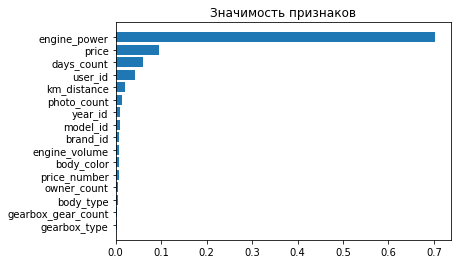

In [24]:
sorted_idx = frm.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], frm.feature_importances_[sorted_idx])
plt.title("Значимость признаков")

Видно, что такие признаки как gearbox_type, gearbox_gear_count, owner_count и body_type практически совсем не влияют на таргет
<p>Удалим эти признаки, чтобы упростить и ускорить процесс обучения модели случайного леса.Также избавимся от оставшихся выбросов: удалим машины, которые были вырущены раньше 1980 года.
<p>После этого заного поделим обработанные данные на обучающую и тестовые выборки и обучим модель с настройками по умолчанию

In [8]:
encoded_data = encoded_data.drop(['gearbox_type', 'gearbox_gear_count', 'owner_count', 'body_type'], 1)
encoded_data = encoded_data[encoded_data.year_id > 1980]
X = encoded_data.drop(['views'], 1)
num_cols2 = list(set(num_cols) - set(['gearbox_gear_count', 'owner_count']))
cat_cols2 = list(set(cat_cols) - set(['gearbox_type', 'body_type']))
X[num_cols2] = X[num_cols2].fillna(calculate_means(X[num_cols2]))
y = encoded_data['views']

(X_train, 
 X_test, 
 y_train, y_test) = train_test_split(X, y, 
                                     test_size=0.2, 
                                     random_state=0)

In [51]:
frm = ensemble.RandomForestRegressor()
frm.fit(X_train, y_train)
predictions = frm.predict(X_test)
print('MAE: ', round(metrics.mean_absolute_error(y_test, predictions), 3))
print('RMSE: ', round(np.sqrt(metrics.mean_squared_error(y_test, predictions)), 3))
print('R2: ', round(frm.score(X_test, y_test), 3))

MAE:  6.661
RMSE:  10.703
R2:  0.938


## Настройка модели
Для начала определим оптимальную глубину деревьев в случаном лесу

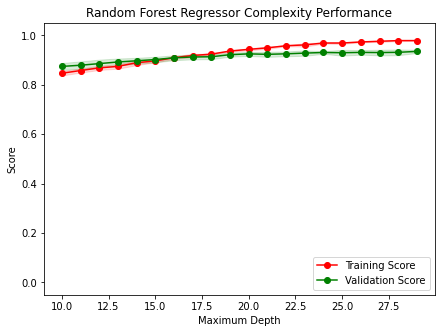

CPU times: user 7min 37s, sys: 31.3 ms, total: 7min 37s
Wall time: 7min 37s


In [53]:
%%time
curves.ModelComplexity_RF(X_train, y_train)

С помощью поиска по сетке уточним оптимальную глубину деревьев, проверив значения от 29 до 34. 
<br>Оптимальным оказалось 33.
<br>Теперь подберем такие параметры модели как:
- n_estimators — количество базовых алгоритмов
- min_samples_split — минимальное количество объектов, необходимое для осуществления деления вершины
- min_samples_leaf — минимальное число объектов в листовой вершине 
- max_features — количество признаков, рассматриваемых при поиске оптимального деления вершины. По умолчанию рассматриваются все признаки, однако существует рекомендованное значение, равное трети от общего количества признаков.


In [9]:
from sklearn.metrics import r2_score

def performance_metric(y_true, y_predict):
    score = r2_score(y_true, y_predict)    
    return score

def best_params(forest):
    return forest.cv_results_['params'][forest.cv_results_['rank_test_score'][0]-1]

def RF_SparkizedGridSearchCV(X, y):
    cv_sets = ShuffleSplit(n_splits = 3, test_size = 0.20, random_state = 42)

    regressor = ensemble.RandomForestRegressor(n_estimators=100, max_depth=33)

#     params = {'max_depth':[32, 33, 34]}
    params = {
        'n_estimators': [10, 50, 100, 150, 200],
        'max_features': ['auto', 'sqrt', 6, 4],
        'min_samples_split': [2, 5, 8, 10],
        'min_samples_leaf': [1, 2, 5, 8]
    }

    scoring_fnc = make_scorer(performance_metric)

    sc = createLocalSparkSession().sparkContext
    grid = GridSearchCV(sc, estimator=regressor, param_grid=params, scoring=scoring_fnc, cv=cv_sets)

    tree_reg = grid.fit(X, y)
    
    return tree_reg

In [9]:
%%time

forest_reg = RF_SparkizedGridSearchCV(X_train, y_train)

bp = best_params(forest_reg)
print(bp)

{'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 150}
CPU times: user 1min 36s, sys: 1.14 s, total: 1min 37s
Wall time: 3h 17min 52s


In [15]:
frm_c = ensemble.RandomForestRegressor(n_estimators=150, max_depth = 33, min_samples_leaf=2, 
                                       min_samples_split=8, max_features='sqrt')
frm_c.fit(X_train, y_train)
predictions = frm_c.predict(X_test)
print('MAE: ', round(metrics.mean_absolute_error(y_test, predictions), 3))
print('RMSE: ', round(np.sqrt(metrics.mean_squared_error(y_test, predictions)), 3))
print('R2: ', round(frm_c.score(X_test, y_test), 3))

MAE:  6.652
RMSE:  11.077
R2:  0.934


In [12]:
rs_df = pd.DataFrame(forest_reg.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop([
            'mean_fit_time', 
            'std_fit_time', 
            'mean_score_time',
            'std_score_time', 
            'params', 
            'split0_test_score', 
            'split1_test_score', 
            'split2_test_score', 
            'std_test_score'],
            axis=1)

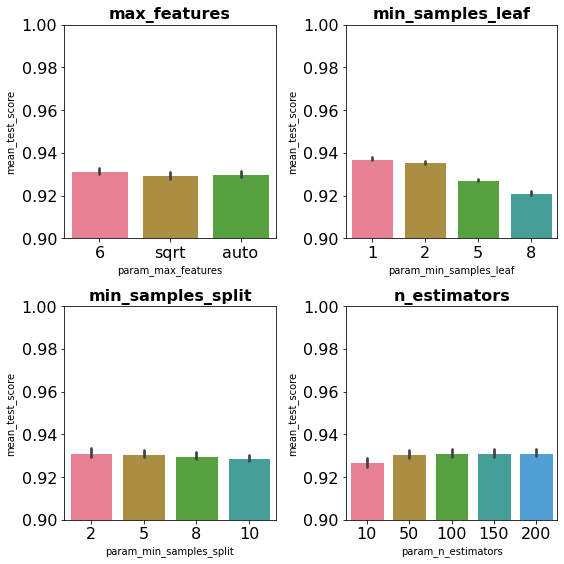

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
sns.set(style="whitegrid")
sns.set_palette("husl")
params = ['max_features', 'min_samples_leaf', 'min_samples_split', 'n_estimators']
for i in range(2):
    for j in range(2):
        param_name = params[j+i*2]
        axs[i,j] = sns.barplot(x='param_'+param_name, y='mean_test_score', data=rs_df, ax=axs[i,j])
        axs[i,j].set_ylim([.90,1.0])
        axs[i,j].set_title(label = param_name, weight='bold', fontsize=16)
        axs[i,j].tick_params(labelsize=16)
fig.tight_layout()

In [20]:
frm_c3 = ensemble.RandomForestRegressor(n_estimators=100, max_depth = 33, max_features=6)
frm_c3.fit(X_train, y_train)
predictions = frm_c3.predict(X_test)
print('MAE: ', round(metrics.mean_absolute_error(y_test, predictions), 3))
print('RMSE: ', round(np.sqrt(metrics.mean_squared_error(y_test, predictions)), 3))
print('R2: ', round(frm_c3.score(X_test, y_test), 3))

MAE:  6.415
RMSE:  10.036
R2:  0.946


## Рассмотрим  работу модели на конкретном примере

In [41]:
test = pd.read_csv('test.csv').drop(['vehicle_id', 'date', 'days_in_sale_from_price_update', 'start_date', 'contacts', 'favorites', 'promo_features_count', 'gearbox_type', 'gearbox_gear_count', 'owner_count', 'body_type'], 1)


In [43]:
les = load('label_encoder_dict2.joblib')
test[cat_cols2] = test[cat_cols2].astype(str)
for f in cat_cols2:
    test[f] = les[f].transform(test[f])

X_ts = test.drop(['views'], 1)
X_ts[num_cols2] = X_ts[num_cols2].fillna(calculate_means(X_ts[num_cols2]))
y_ts = test['views']

Предсказываем количество просмотров с помощью построенной модели на данных примера

In [44]:
pred_ts = frm_c5.predict(X_ts)

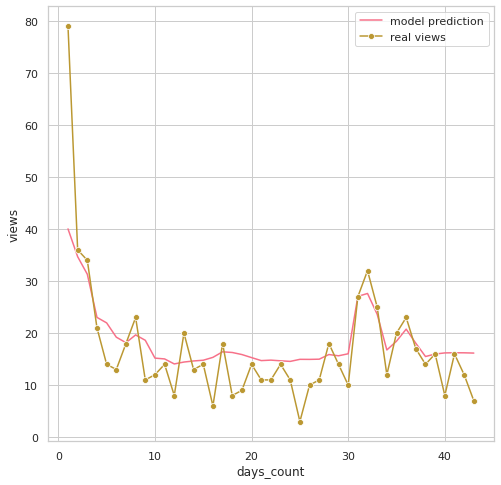

In [86]:
fig, axs = plt.subplots(figsize=(8,8))
sns.set_palette("husl", 2)
sns.lineplot(x = X_ts['days_count'], y = pred_ts)
sns.lineplot(x = X_ts['days_count'], y = y_ts, marker="o")
plt.legend(labels=['model prediction', 'real views'])

Конвертируем полученное количество просмотров в звонки для интерпретации результатов
<p>При этом сравниваем полученные результаты с реальными данными. 

In [101]:
table = pd.DataFrame()
table['days_count'] = [7, 10, 30]
table['views_pred'] = [sum(pred_ts[:7]), sum(pred_ts[:10]), sum(pred_ts[:30])]
table['views_real'] = [sum(y_ts[:7]), sum(y_ts[:10]), sum(y_ts[:30])]
table['calls_pred'] = [table['views_pred'][0]*0.013, table['views_pred'][1]*0.013, table['views_pred'][2]*0.013]
table['calls_real'] = [table['views_real'][0]*0.013, table['views_real'][1]*0.013, table['views_real'][2]*0.013]
table.astype(int)

,days_count,views_pred,views_real,calls_pred,calls_real
0,7,188,215,2,2
1,10,241,261,3,3
2,30,545,498,7,6


<p>Поскольку в среднем машина продается за 6-7 звонков, расхождение в результатах за период в 30 дней не повлияет на интерпретацию результатов модели. Из этого можно сделать вывод, что полученные значения метрик качества являются приемлемыми для данной задачи.
<p>Результаты, полученные моделью в рассмотренном примере, интерпретируются следующим образом: в первые 7 дней будет получено 2 звонка, а за 30 дней прогнозируется целевое количество звонков для дилера, значит, применять переоценку нет необходимости, так как скорее всего машина будет продана в первый месяц, то есть за целевой срок оборачиваемости. 